In [ ]:
# @title Setup for Google Colab
# Run this cell if you are using Google Colab to set up the environment.

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Setting up environment...")

    # 1. Clone the repository
    !git clone https://github.com/Boussyf0/MANTIS-Maintenance-Intelligence-System-.git mantis_repo

    # 2. Change working directory
    import os
    os.chdir('mantis_repo')

    # 3. Create data directories
    if not os.path.exists('data/raw/NASA_CMAPSS'):
        os.makedirs('data/raw/NASA_CMAPSS')

    # 4. Download and unzip dataset (Robust w/ mirrors)
    if not os.path.exists('data/raw/NASA_CMAPSS/train_FD001.txt'):
        print("Downloading NASA CMAPSS Data...")

        urls = [
            'https://data.nasa.gov/api/views/s96h-rxk2/files/8b8e05a8-6f16-43b6-96b6-81a171ef9948?download=true&filename=CMAPSSData.zip',
            'https://raw.githubusercontent.com/senthilnayagan/CMS_DeepLearning/master/CMAPSSData.zip',
            'https://data.nasa.gov/docs/legacy/CMAPSSData.zip'
        ]

        success = False
        for url in urls:
            print(f"Trying {url}...")
            try:
                exit_code = os.system(f'wget "{url}" -O data/raw/NASA_CMAPSS/CMAPSSData.zip')
                if exit_code == 0:
                    success = True
                    print("Download successful.")
                    break
            except Exception as e:
                print(f"Failed: {e}")

        if success:
            !unzip -o data/raw/NASA_CMAPSS/CMAPSSData.zip -d data/raw/NASA_CMAPSS/
            print("Data extracted.")
        else:
            print("CRITICAL: All download mirrors failed. Please upload data manually.")

    # 5. Switch to notebooks directory so relative paths work
    os.chdir('notebooks')
    print("Setup complete. Current working directory:", os.getcwd())

Running in Google Colab. Setting up environment...
Cloning into 'mantis_repo'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 749 (delta 4), reused 70 (delta 4), pack-reused 654 (from 1)
Receiving objects: 100% (749/749), 102.09 MiB | 21.82 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Trying https://data.nasa.gov/api/views/s96h-rxk2/files/8b8e05a8-6f16-43b6-96b6-81a171ef9948?download=true&filename=CMAPSSData.zip...
Trying https://raw.githubusercontent.com/senthilnayagan/CMS_DeepLearning/master/CMAPSSData.zip...
Trying https://data.nasa.gov/docs/legacy/CMAPSSData.zip...
Download successful.
Archive:  data/raw/NASA_CMAPSS/CMAPSSData.zip
  inflating: data/raw/NASA_CMAPSS/Damage Propagation Modeling.pdf  
  inflating: data/raw/NASA_CMAPSS/readme.txt  
  inflating: data/raw/NASA_CMAPSS/RUL_FD001.txt  
  inflating: data/raw/NASA_CMAPSS/RUL_FD002.txt  
  inflating: data/raw/NASA_CMA

# Exploration du dataset NASA C-MAPSS

Ce notebook explore le dataset NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) utilisé pour l'entraînement des modèles de prédiction RUL.

## Dataset

- **Source**: NASA Prognostics Center of Excellence
- **Description**: Données de dégradation de moteurs turbofan
- **4 sous-datasets**: FD001, FD002, FD003, FD004
- **21 capteurs**: Températures, pressions, vitesses, débits
- **3 réglages opérationnels**

## Objectif

Prédire la Remaining Useful Life (RUL) en cycles avant défaillance.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Largeur figures
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Chargement des données

In [ ]:
# Chemins
DATA_DIR = Path('../../data/raw/NASA_CMAPSS')

# Noms des colonnes
index_cols = ['unit_number', 'time_cycles']
setting_cols = ['setting_1', 'setting_2', 'setting_3']
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
col_names = index_cols + setting_cols + sensor_cols

# Charger FD001
train = pd.read_csv(
    DATA_DIR / 'train_FD001.txt',
    sep='\\s+',
    header=None,
    names=col_names
)

test = pd.read_csv(
    DATA_DIR / 'test_FD001.txt',
    sep='\\s+',
    header=None,
    names=col_names
)

rul_truth = pd.read_csv(
    DATA_DIR / 'RUL_FD001.txt',
    sep='\\s+',
    header=None,
    names=['RUL']
)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"RUL truth shape: {rul_truth.shape}")

Train shape: (20631, 26)
Test shape: (13096, 26)
RUL truth shape: (100, 1)


In [ ]:
# Aperçu des données
train.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
# Statistiques descriptives
train.describe()

,unit_number,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## 2. Calcul de la RUL pour le training set

In [ ]:
# Pour chaque unit, la RUL = cycles max - cycle actuel
def add_rul(df):
    """Ajoute la colonne RUL au dataframe."""
    df = df.copy()

    # Calculer le cycle max pour chaque unit
    max_cycles = df.groupby('unit_number')['time_cycles'].max().reset_index()
    max_cycles.columns = ['unit_number', 'max_cycle']

    # Merge
    df = df.merge(max_cycles, on='unit_number', how='left')

    # Calculer RUL
    df['RUL'] = df['max_cycle'] - df['time_cycles']

    # Drop max_cycle
    df = df.drop('max_cycle', axis=1)

    return df

train = add_rul(train)

print(f"RUL range: {train['RUL'].min()} - {train['RUL'].max()}")
train[['unit_number', 'time_cycles', 'RUL']].head(10)

RUL range: 0 - 361


,unit_number,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
5,1,6,186
6,1,7,185
7,1,8,184
8,1,9,183
9,1,10,182


## 3. Analyse exploratoire

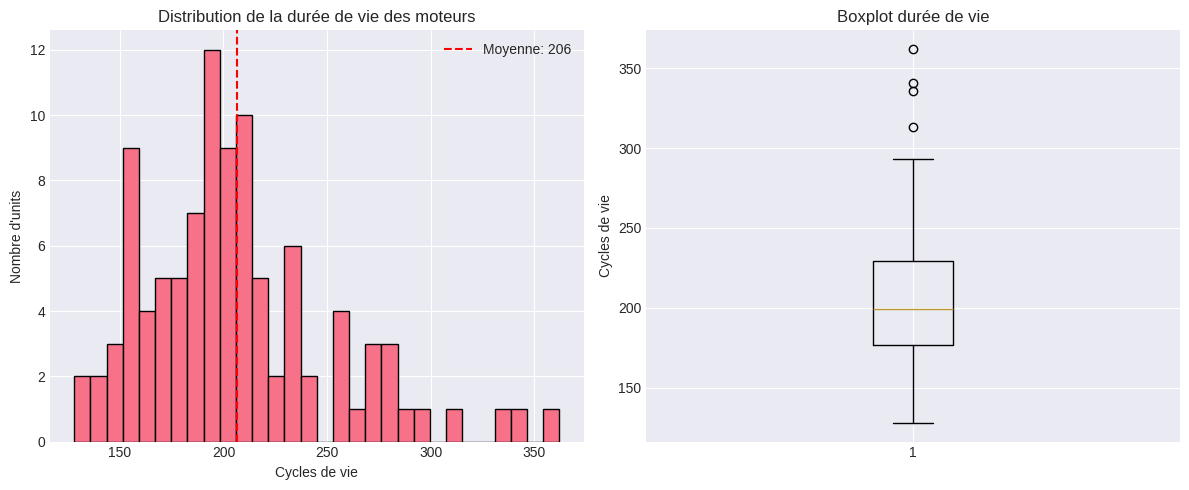

Moyenne: 206.31 cycles
Médiane: 199.00 cycles
Min: 128 cycles
Max: 362 cycles


In [ ]:
# Distribution de la durée de vie des units
unit_lifetimes = train.groupby('unit_number')['time_cycles'].max()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(unit_lifetimes, bins=30, edgecolor='black')
plt.xlabel('Cycles de vie')
plt.ylabel('Nombre d\'units')
plt.title('Distribution de la durée de vie des moteurs')
plt.axvline(unit_lifetimes.mean(), color='red', linestyle='--', label=f'Moyenne: {unit_lifetimes.mean():.0f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(unit_lifetimes)
plt.ylabel('Cycles de vie')
plt.title('Boxplot durée de vie')

plt.tight_layout()
plt.show()

print(f"Moyenne: {unit_lifetimes.mean():.2f} cycles")
print(f"Médiane: {unit_lifetimes.median():.2f} cycles")
print(f"Min: {unit_lifetimes.min()} cycles")
print(f"Max: {unit_lifetimes.max()} cycles")

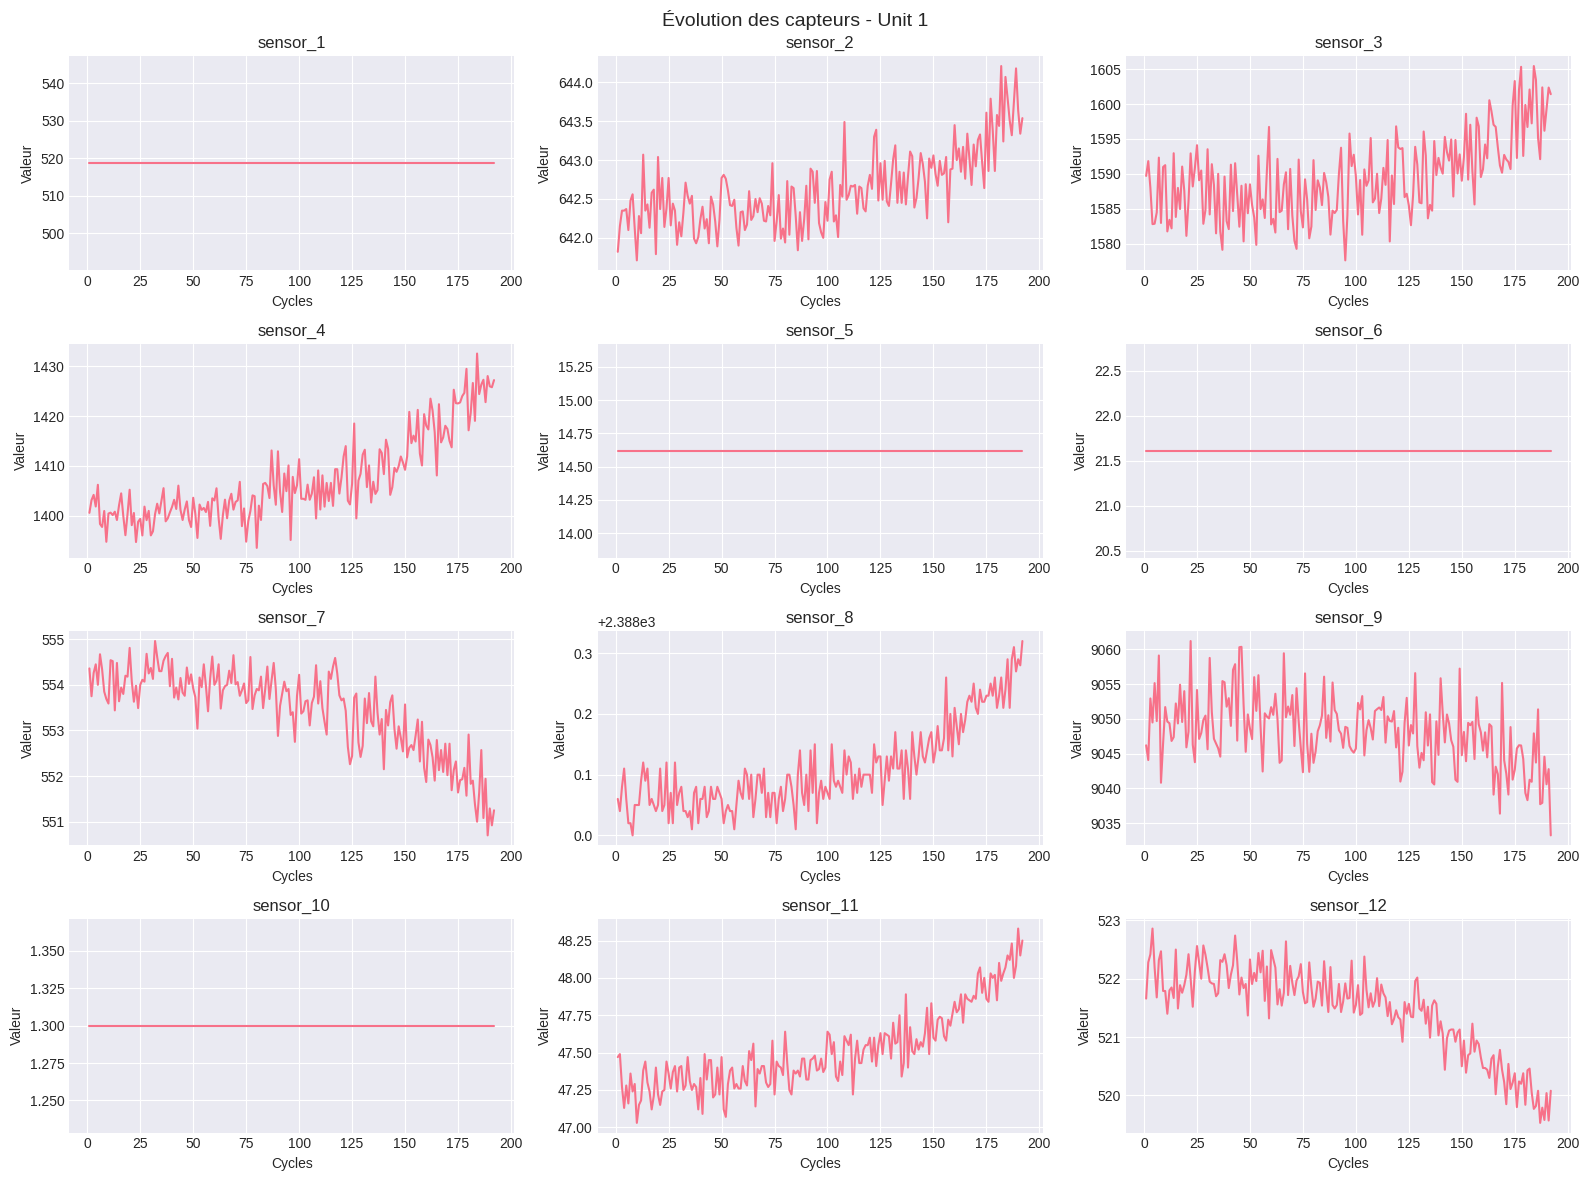

In [ ]:
# Évolution des capteurs pour un moteur exemple
unit_example = 1
unit_data = train[train['unit_number'] == unit_example]

fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()

for i, sensor in enumerate(sensor_cols[:12]):
    axes[i].plot(unit_data['time_cycles'], unit_data[sensor])
    axes[i].set_xlabel('Cycles')
    axes[i].set_ylabel('Valeur')
    axes[i].set_title(f'{sensor}')
    axes[i].grid(True)

plt.suptitle(f'Évolution des capteurs - Unit {unit_example}', fontsize=14)
plt.tight_layout()
plt.show()

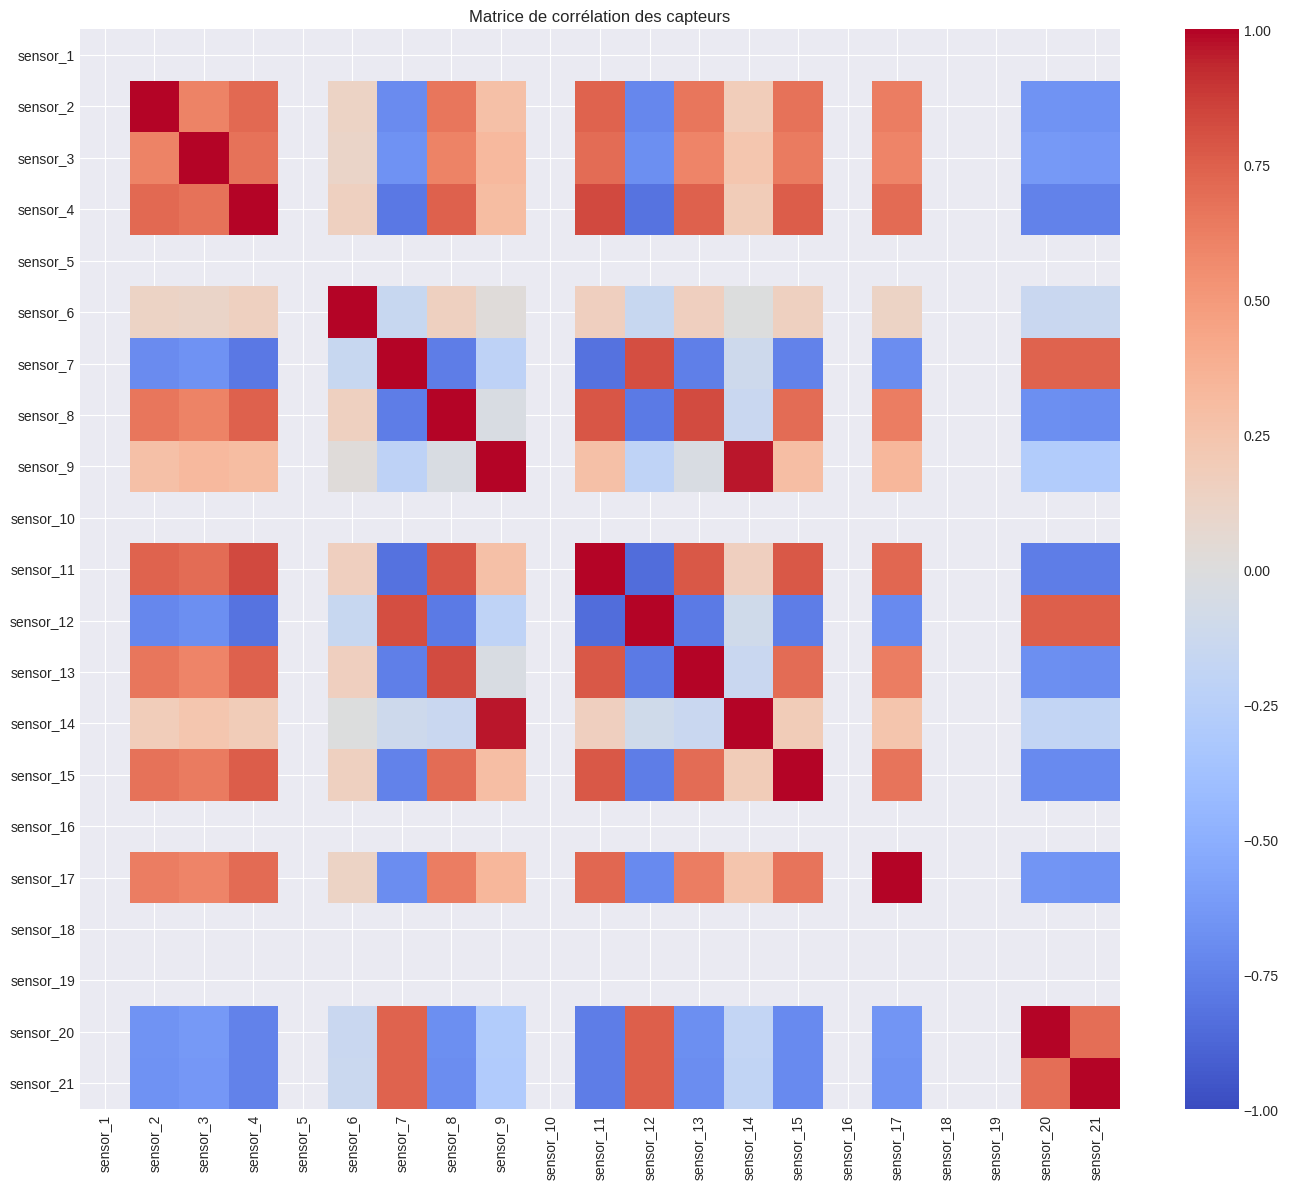

In [ ]:
# Corrélation entre capteurs
plt.figure(figsize=(14, 12))
correlation = train[sensor_cols].corr()
sns.heatmap(correlation, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Matrice de corrélation des capteurs')
plt.tight_layout()
plt.show()

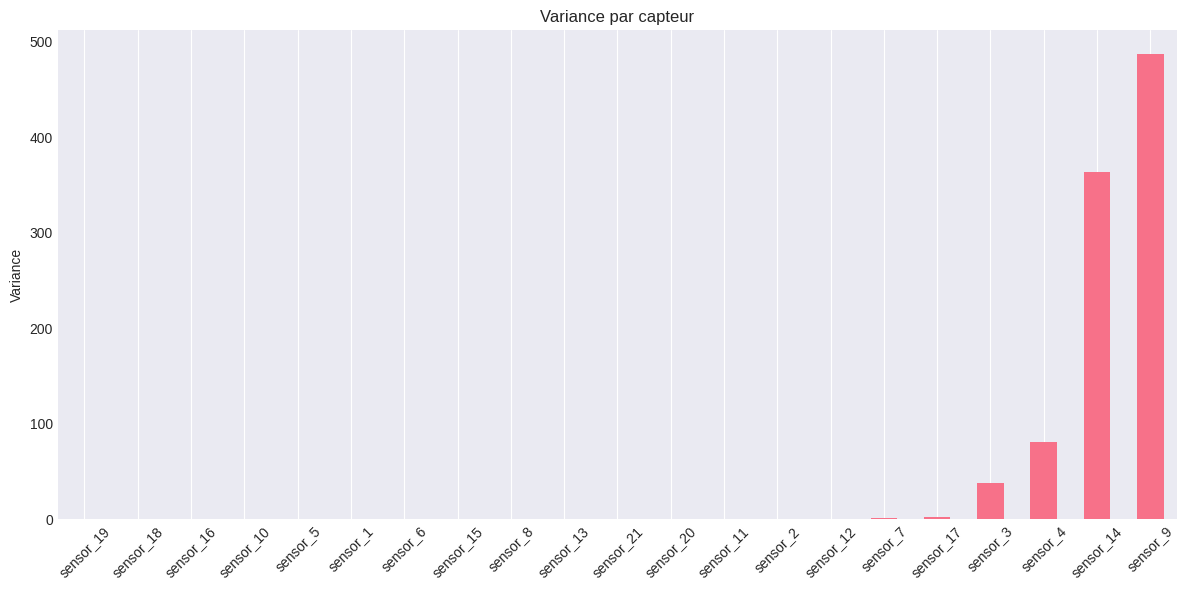


Capteurs avec variance quasi-nulle (< 0.01):
sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    2.422479e-28
sensor_10    2.172333e-25
sensor_5     1.152399e-23
sensor_1     4.273435e-21
sensor_6     1.929279e-06
sensor_15    1.406628e-03
sensor_8     5.038938e-03
sensor_13    5.172330e-03
dtype: float64


In [ ]:
# Variance des capteurs (identifier capteurs constants)
sensor_variance = train[sensor_cols].var().sort_values()

plt.figure(figsize=(12, 6))
sensor_variance.plot(kind='bar')
plt.ylabel('Variance')
plt.title('Variance par capteur')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("\nCapteurs avec variance quasi-nulle (< 0.01):")
print(sensor_variance[sensor_variance < 0.01])

## 4. Évolution des capteurs en fonction de la RUL

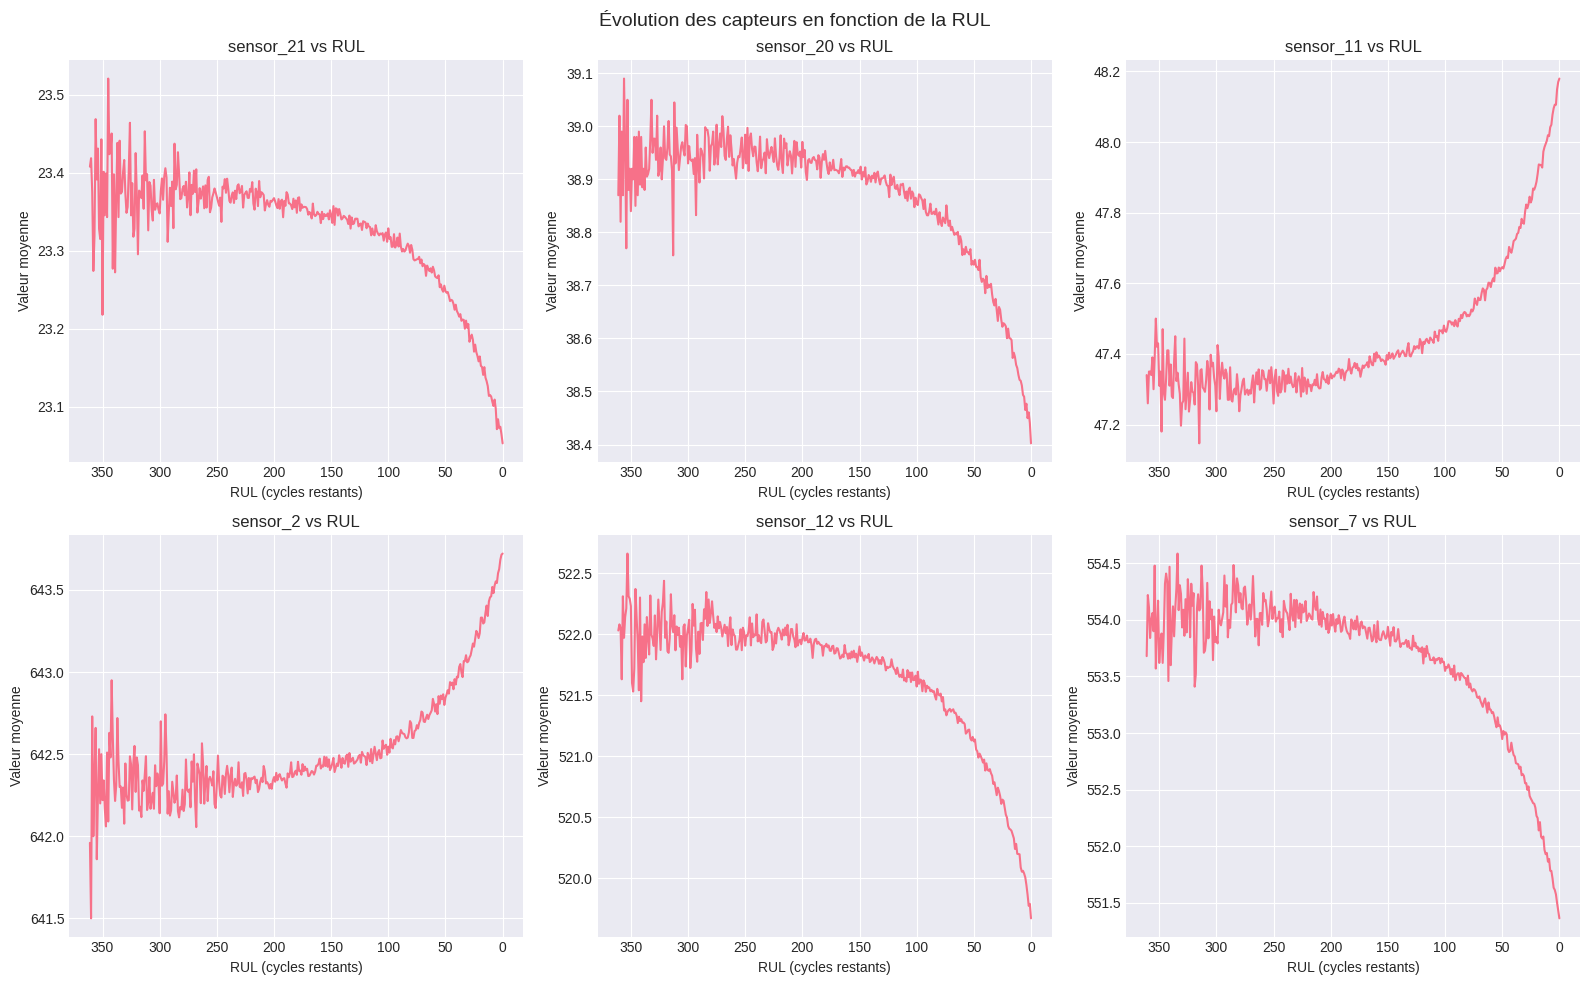

In [ ]:
# Sélectionner des capteurs avec variance significative
significant_sensors = sensor_variance[sensor_variance > 0.01].index.tolist()[:6]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, sensor in enumerate(significant_sensors):
    # Moyenner par RUL (pour lisibilité)
    rul_grouped = train.groupby('RUL')[sensor].mean()

    axes[i].plot(rul_grouped.index, rul_grouped.values)
    axes[i].set_xlabel('RUL (cycles restants)')
    axes[i].set_ylabel('Valeur moyenne')
    axes[i].set_title(f'{sensor} vs RUL')
    axes[i].invert_xaxis()  # RUL décroît
    axes[i].grid(True)

plt.suptitle('Évolution des capteurs en fonction de la RUL', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Feature engineering basique

In [ ]:
# Calculer rolling mean et rolling std sur fenêtre de 5 cycles
window = 5

def add_rolling_features(df, sensors, window=5):
    """Ajoute rolling mean et std pour les capteurs."""
    df = df.copy()

    for sensor in sensors:
        df[f'{sensor}_rolling_mean'] = df.groupby('unit_number')[sensor].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'{sensor}_rolling_std'] = df.groupby('unit_number')[sensor].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

    return df

# Appliquer sur quelques capteurs
train_fe = add_rolling_features(train, significant_sensors[:3], window=5)

print(f"Nouvelles features ajoutées:")
print([col for col in train_fe.columns if 'rolling' in col])

Nouvelles features ajoutées:
['sensor_21_rolling_mean', 'sensor_21_rolling_std', 'sensor_20_rolling_mean', 'sensor_20_rolling_std', 'sensor_11_rolling_mean', 'sensor_11_rolling_std']


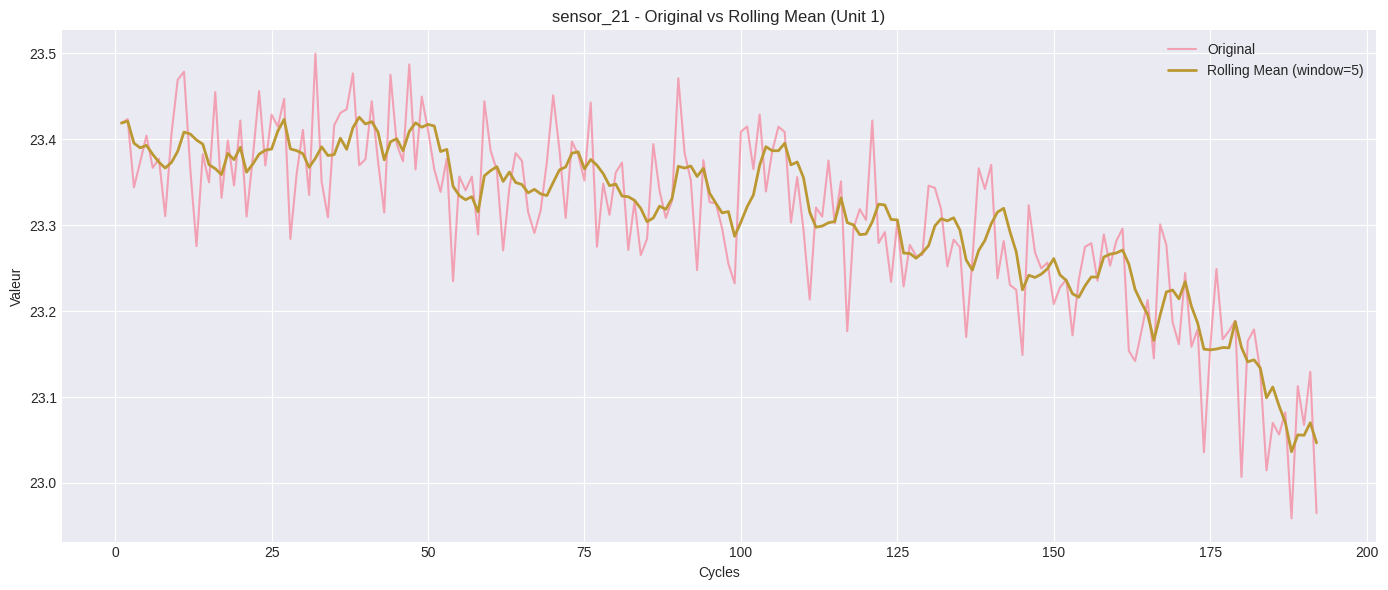

In [ ]:
# Visualiser l'effet du rolling mean
unit_example = 1
sensor_example = significant_sensors[0]
unit_data = train_fe[train_fe['unit_number'] == unit_example]

plt.figure(figsize=(14, 6))
plt.plot(unit_data['time_cycles'], unit_data[sensor_example], label='Original', alpha=0.6)
plt.plot(unit_data['time_cycles'], unit_data[f'{sensor_example}_rolling_mean'],
         label=f'Rolling Mean (window={window})', linewidth=2)
plt.xlabel('Cycles')
plt.ylabel('Valeur')
plt.title(f'{sensor_example} - Original vs Rolling Mean (Unit {unit_example})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Préparation pour modélisation

### Clip RUL pour éviter l'instabilité

Souvent, on limite la RUL max à un seuil (ex: 125 cycles) car au-delà, l'équipement est considéré "sain" et la prédiction exacte est moins importante.

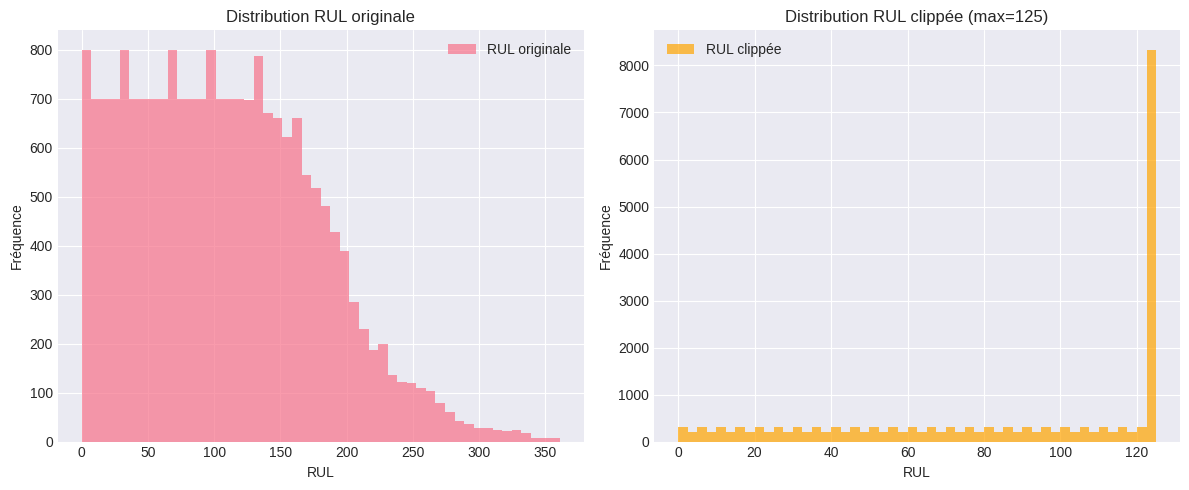

In [ ]:
# Clip RUL à 125
max_rul = 125
train_fe['RUL_clipped'] = train_fe['RUL'].clip(upper=max_rul)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train_fe['RUL'], bins=50, alpha=0.7, label='RUL originale')
plt.xlabel('RUL')
plt.ylabel('Fréquence')
plt.title('Distribution RUL originale')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(train_fe['RUL_clipped'], bins=50, alpha=0.7, label='RUL clippée', color='orange')
plt.xlabel('RUL')
plt.ylabel('Fréquence')
plt.title(f'Distribution RUL clippée (max={max_rul})')
plt.legend()

plt.tight_layout()
plt.show()

## 7. Sauvegarde des données préparées

In [ ]:
# Sauvegarder pour usage futur
output_dir = Path('../../data/processed')
output_dir.mkdir(exist_ok=True)

train_fe.to_parquet(output_dir / 'train_FD001_features.parquet', index=False)
print(f"✓ Sauvegardé: {output_dir / 'train_FD001_features.parquet'}")
print(f"Shape: {train_fe.shape}")
print(f"Colonnes: {len(train_fe.columns)}")

✓ Sauvegardé: ../data/processed/train_FD001_features.parquet
Shape: (20631, 34)
Colonnes: 34


## Conclusion

Ce notebook a permis de:
- ✅ Charger et explorer le dataset NASA C-MAPSS FD001
- ✅ Calculer la RUL pour le training set
- ✅ Analyser la distribution des durées de vie
- ✅ Identifier les capteurs informatifs
- ✅ Créer des features de base (rolling mean/std)
- ✅ Préparer les données pour modélisation

**Prochaines étapes**:
1. Feature extraction avancée (FFT, wavelets, kurtosis, etc.)
2. Entraînement modèle LSTM/GRU
3. Évaluation et tuning
4. Transfer learning vers données usine

Voir `02-rul-model-training.ipynb` pour la suite.